# IMPORTS

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys
from glob import glob
import scipy.stats
from collections import defaultdict
import pickle
import itertools
import copy
import math

In [2]:
def symbol(name : str) -> str:
    if 'FS-' in name.upper():
        return '^'
    elif 'FT-' in name.upper():
        return 's'
    else:
        return 'o'

In [3]:
def translate(r, minus_one_reward_for_leaving_map = False):
    if r >= 0:
        return r
    hundred = round(r / 100)
    real_r = r - (abs(hundred) * -100)
    if minus_one_reward_for_leaving_map: real_r += hundred
    return real_r

In [4]:
# plt.style.use('./matplotlib.rc')

In [5]:
# plt.rcParams.update({'font.size': 18})
# plt.rcParams.update({'axes.titlesize' : 24})

# FIREFIGHTING

In [6]:
with open('final_results/final_camera_ready_fff_5s_results.pickle', 'rb') as handle:
    fff_results = pickle.load(handle)

In [7]:
# cmap = plt.get_cmap('Set1')

linear_colours = False
if linear_colours:
    cmap_pomcp = plt.get_cmap('Reds')
    cmap_pft = plt.get_cmap('Blues')
else:
    cmap_pomcp = plt.get_cmap('tab20')
    cmap_pft = plt.get_cmap('tab20')

In [8]:
def build_better_fff_plot(results, outname = "undefined", rs_map_size = '15-15', solid_line = (lambda name : ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name), even_spacing_xaxis = True, only_weighted=False, only_cg=False, discounted=False, pft=False, pomcp=True, **figure_kwargs):
    # title += f" ($n_f=3$, $H=10, c=5, \gamma={0.99 if discounted else 1}$)" 
    fig = plt.figure(**figure_kwargs)
    # plt.suptitle(title)
    disc_index = 'discounted' if discounted else 'undiscounted'
    for i, act_select in enumerate(['VE', 'MP']):
        print("Generating plot for:", act_select)
        plt.subplot(1, 2, i+1)
        title = "Variable Elimination" if act_select == 'VE' else "MaxPlus"
        plt.title(title)
        agents = sorted(list(results.keys()))
        randoms = []
        randoms_ci = []
        print(agents, type(agents[0]))
        means_dict, stds_dict = defaultdict(list), defaultdict(list)
        pft_names = set()
        pomcp_names = set()
        names = set()
        c = pomc = None
        for (j, agent) in enumerate(agents):
            sim_values = results[agent]
            sims = sorted([s for s in sim_values.keys() if type(s) == int])
            sim = sims[-1]
            the_random = [s for s in sim_values.keys() if type(s) == str]
            assert len(the_random) == 1
            the_random = the_random[0]
            res = sim_values[the_random][disc_index]
            trace = res.values.sum(axis=1)
            avg, std = trace.mean(), trace.std()
            scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
            std = [avg - scipy_ci[0], scipy_ci[1] - avg]
            randoms.append(avg)
            randoms_ci.append(std)
            for name in sim_values[sim].keys():
                result = sim_values[sim][name]
                name = name.replace(f'fff_n{agent}_h10_c5_s{sim}_', '').replace('_', '-').upper()
                if not act_select.upper() in name.upper():
                    if "VE" in name.upper() or "MP" in name.upper():
                        continue
                trace = result[disc_index].values
                if np.size(trace) == 0:
                    # Failed experiment, e.g. flat pomcp with many agents
                    # means_dict[name].append(random-1)
                    # stds_dict[name].append([0, 0])
                    continue
                if 'pft' in name.lower():
                    pft_names.add(name) 
                elif 'pomcp' in name.lower():
                    pomcp_names.add(name)
                else:
                    print(name)
                names.add(name)
                trace = trace.sum(axis=1)
                avg, std = trace.mean(), trace.std()
                scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
                std = [avg - scipy_ci[0], scipy_ci[1] - avg]
                means_dict[name].append(avg)
                stds_dict[name].append(std)
        print(means_dict.items())
        if c is None:
            color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
            c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
        if pomc is None:
            color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
            pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
        for name in sorted(pft_names):
            if not pft: continue
            means = means_dict[name]
            stds = stds_dict[name]
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            assert name in c, (name, c)
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=name.replace("-VE", "").replace("-MP", "").replace("-WPF", ""), alpha=0.7, color=c[name])
        for name in sorted(pomcp_names):
            if not pomcp: continue
            means = means_dict[name]
            stds = stds_dict[name]
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            assert name in pomc, (name, pomc)
            label = name.replace("-VE", "").replace("-MP", "")
            if only_weighted: 
                if not "-WPF" in name.upper(): continue
                # label = label.replace("-WPF", "")
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=pomc[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
            # plt.gca().set_xticklabels(agents)

        if even_spacing_xaxis: plt.xticks(list(range(len(agents))), agents)
        # plt.yscale('log')
        plt.ylim([-150, -5])
        print(agents, randoms)
        plt.errorbar(list(range(len(randoms))) if even_spacing_xaxis else agents, randoms, yerr=np.transpose(randoms_ci), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
        # plt.errorbar(list(range(len(agents)))[0], -8.25793, -7.89799 - -8.25793, label='SARSOP', linestyle=(5, (10, 3)), linewidth=5, capsize=5, c='black', alpha=1)
        plt.xlabel("Number of Agents")
        plt.ylabel("Cumulative Discounted Reward")
            # plt.legend(fontsize='xx-small')
        if i == 0:
            plt.legend()
    # fig.supxlabel("Number of Agents")
    # fig.supylabel("Cumulative Discounted Reward")
    plt.tight_layout()
    # fig.savefig(outname + ".pdf", format='pdf', backend='pgf')
    plt.savefig(outname, backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    return means_dict, stds_dict

In [9]:
fff_results_3_v2 = copy.deepcopy(fff_results)
# del fff_results_3_v2[32]

Generating plot for: VE
[4, 16, 32, 64] <class 'int'>
dict_items([('POMCP-WPF', [-9.552255774278972, -31.760208553704633]), ('POMCP', [-7.9349052107666616, -38.96710033660584]), ('FS-POMCP-VE-WPF', [-10.909583847652486, -28.68562014421048, -62.140127756539776, -123.53192712775387]), ('FS-POMCP-VE', [-10.380885320132716, -46.33088037591262, -76.1985377513181, -142.19397853285054]), ('FT-POMCP-VE-WPF', [-9.917161286572771, -24.727770952430525, -42.37529387170348, -80.39372120467024]), ('FT-POMCP-VE', [-8.888317121435119, -24.113904035961113, -41.93427322690958, -81.21788344841711]), ('PFT-WPF', [-10.234662507476175, -32.36794556654899]), ('FS-PFT-VE-WPF', [-12.628876167230565, -32.785783529099426, -60.803196371279235, -131.73401165841653]), ('FT-PFT-VE-WPF', [-11.848637326074687, -34.39876442365825, -60.15145224880468, -124.77758045763748])])
[4, 16, 32, 64] [-18.724040930671002, -43.73759555390661, -76.84108917607617, -144.22958234990173]
Generating plot for: MP
[4, 16, 32, 64] <class '

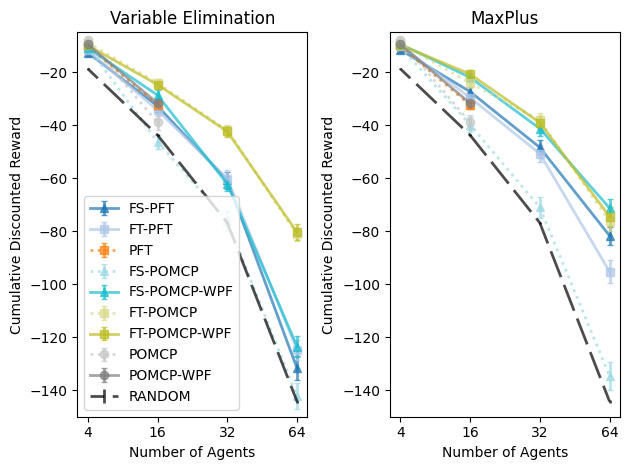

In [10]:
_ = build_better_fff_plot(fff_results_3_v2, outname="plot_output/better-fff", only_cg=False, only_weighted=False, pft=True, pomcp=True, discounted=True)

In [11]:
def build_specific_fff_plot(results, sub_plot_shape=(3, 1), outname = "undefined", only64=False, solid_line = (lambda name : ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name), even_spacing_xaxis = True, only_weighted=False, only_cg=False, discounted=False, pft=False, pomcp=True, **figure_kwargs):
    cmap = plt.get_cmap('tab20')
    title = "\\textsc{FireFightingGraph}"
    fig = plt.figure(**figure_kwargs)
    # plt.suptitle(title)
    disc_index = 'discounted' if discounted else 'undiscounted'
    c = pomc = None
    for (i, agent) in enumerate(results.keys()):
        if only64:
            i = 0
            agent = sorted(list(results.keys()))[-1]
        else:
            plt.subplot(sub_plot_shape[0], sub_plot_shape[1], i+1)
        plt.title(f"{agent}"+ " Agents")
        sim_values = results[agent]
        sims = sorted([s for s in sim_values.keys() if type(s) == int])
        means_dict, stds_dict = defaultdict(list), defaultdict(list)
        pft_names = set()
        pomcp_names = set()
        names = set()
        print(agent, sim_values.keys())
        for sim in sim_values.keys():
            if type(sim) == str:
                res = sim_values[sim][disc_index]
                trace = res.values.sum(axis=1)
                random_avg = trace.mean()
                scipy_ci = scipy.stats.norm.interval(0.95, loc=random_avg, scale=scipy.stats.sem(trace))
                random_std = [random_avg - scipy_ci[0], scipy_ci[1] - random_avg]
            else:
                for name in sim_values[sim].keys():
                    result = sim_values[sim][name]
                    name = name.replace(f'fff_n{agent}_h10_c5_s{sim}_', '').replace('_', '-').upper()
                    # if "FT-POMCP" in name or "PFT" in name or "WPF" in name:
                    if "VE" in name:
                        continue
                    # else:
                        # continue
                    trace = result[disc_index].values
                    if np.size(trace) == 0:
                        # Failed experiment, e.g. flat pomcp with many agents
                        # means_dict[name].append(random-1)
                        # stds_dict[name].append([0, 0])
                        continue
                    if 'pft' in name.lower():
                        pft_names.add(name) 
                    elif 'pomcp' in name.lower():
                        pomcp_names.add(name)
                    else:
                        print(name)
                    names.add(name)
                    trace = trace.sum(axis=1)
                    avg, std = trace.mean(), trace.std()
                    scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
                    std = [avg - scipy_ci[0], scipy_ci[1] - avg]
                    means_dict[name].append(avg)
                    stds_dict[name].append(std)
        if c is None:
            color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
            c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
        if pomc is None:
            color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
            pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
        for name in sorted(pft_names):
            if not pft: continue
            means = means_dict[name]
            stds = stds_dict[name]
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(sims) == len(stds), (name, (means, stds, sims))
            assert name in c, (name, c)
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            label = name.replace("-VE", "").replace("-MP", "").replace("-WPF", "")
            label = "Sparse-PFT" if label == "PFT" else label
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else sims[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=c[name])
        for name in sorted(pomcp_names):
            if not pomcp: continue
            means = means_dict[name]
            stds = stds_dict[name]
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(sims) == len(stds), (name, (means, stds, sims))
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            assert name in pomc, (name, pomc)
            label = name.replace("-VE", "").replace("-MP", "")
            if only_weighted: 
                if not "-WPF" in name.upper(): continue
            label = label.replace("POMCP-WPF", "W-POMCP")
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=pomc[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else sims[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
            # plt.gca().set_xticklabels(agents)

        if even_spacing_xaxis: plt.xticks(list(range(len(sims))), sims)
        plt.errorbar(list(range(len(sims))) if even_spacing_xaxis else sims, [random_avg for _ in range(len(sims))], yerr=np.transpose([random_std for _ in range(len(sims))]), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
        plt.xlabel("Number of Agents")
        plt.xscale('log')
        plt.ylabel("Cumulative Discounted Reward")
        if i == 0:
            plt.legend()
        if agent == 4:
            # SARSOP result
            plt.errorbar(sims, [-8.25793 for _ in sims], [-7.89799 - -8.25793 for _ in sims], label='SARSOP', linestyle=(5, (10, 3)), linewidth=2, c='gold', alpha=1)
        if i == 0:
            plt.legend()
        plt.xlabel("Number of Simulations")
        plt.ylabel("Cumulative Discounted Reward")
        if only64:
            break
    plt.tight_layout()
    plt.savefig(outname, backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    return means_dict, stds_dict

In [12]:
with open('final_results/results_fff_multiple_sims.pickle', 'rb') as handle: # current
    fff_sims_results = pickle.load(handle)

4 dict_keys(['fff_n4_h10_RANDOM', 10, 25, 50, 100, 250, 1000])
16 dict_keys(['fff_n16_h10_RANDOM', 10, 25, 50, 100, 250, 1000])
64 dict_keys(['fff_n64_h10_RANDOM', 10, 25, 50, 100, 250, 1000])


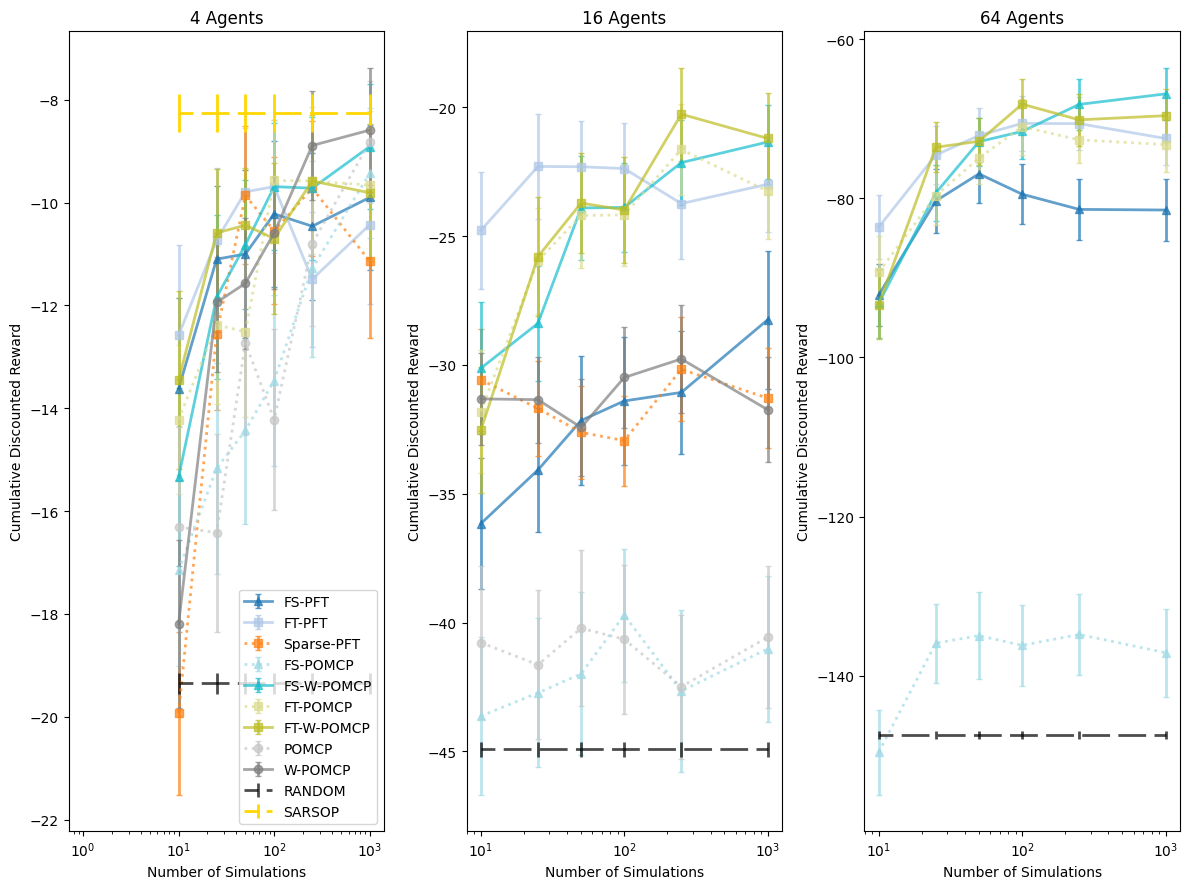

In [13]:
fff_results_3_v3 = copy.deepcopy(fff_sims_results)
del fff_results_3_v3[32]
_ = build_specific_fff_plot(fff_results_3_v3, even_spacing_xaxis=False, pft=True, outname="plot_output/ffg-comparison", sub_plot_shape=(1,3), only64=False, figsize=(12, 9))

64 dict_keys(['fff_n64_h10_RANDOM', 10, 25, 50, 100, 250, 1000])


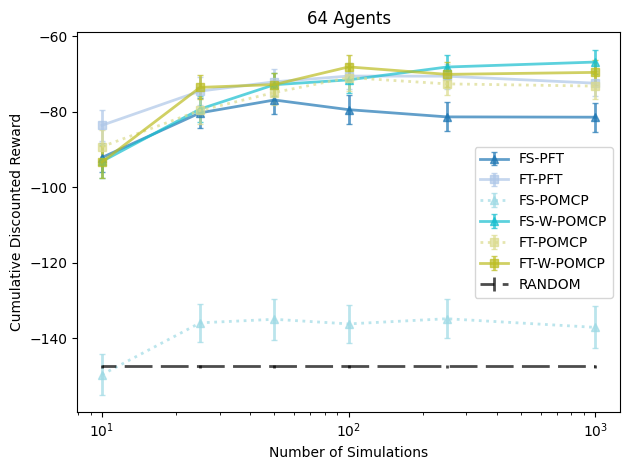

In [14]:
fff_results_3_v3 = copy.deepcopy(fff_sims_results)
del fff_results_3_v3[32]
_ = build_specific_fff_plot(fff_results_3_v3, even_spacing_xaxis=False, pft=True, outname="plot_output/ffg-comparison-64-only", sub_plot_shape=(1,3), only64=True)

# Final plots

In [15]:

dirname = 'final_results/final_camera_ready_fff_5s_results.pickle'
with open(dirname, 'rb') as handle:
    fff_results = pickle.load(handle)

In [16]:
dirname = 'final_results/final_camera_ready_mars_15s_results'
with open(dirname + '.pickle', 'rb') as handle:
    mars_results = pickle.load(handle)

In [43]:
def clean(c : str):
    return c.replace("mars-15-15", "").replace("mars-11-11", "").replace("mars-7-8", "").replace('-line', "").replace("-team", "").replace("_n3", "").replace("_n4", "").replace("_n5", "").replace("_n6", "").replace("_h40_c1.25_s10000_".upper(), "").replace("_h40_c1.25_s10000_", "").replace("_", "-")

In [44]:
# cmap = plt.get_cmap('Set1')

linear_colours = False
if linear_colours:
    cmap_pomcp = plt.get_cmap('Reds')
    cmap_pft = plt.get_cmap('Blues')
else:
    cmap_pomcp = plt.get_cmap('tab20')
    cmap_pft = plt.get_cmap('tab20')

In [45]:
fff_results.keys()

dict_keys([4, 16, 32, 64])

In [46]:
def build_wpf_plot(results_fff, results_mars, outname = "undefined", rs_map_size = '15-15', remove_exit_map = True, solid_line = (lambda name : ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name), even_spacing_xaxis = True, only_weighted=False, only_cg=False, discounted=False, pft=False, pomcp=True, **figure_kwargs):
    # title += f" ($n_f=3$, $H=10, c=5, \gamma={0.99 if discounted else 1}$)" 
    fig = plt.figure(**figure_kwargs)
    # plt.suptitle(title)
    disc_index = 'discounted' if discounted else 'undiscounted'
    act_select = 'MP'
    # BUILD FFF SUBPLOT
    plt.subplot(1, 2, 1)
    # plt.title("\\textsc{FFG}, " + act_select)
    plt.title("\\textsc{FireFightingGraph}")
    agents = sorted(list(results_fff.keys()))
    randoms = []
    randoms_ci = []
    means_dict, stds_dict = defaultdict(list), defaultdict(list)
    pft_names = set()
    pomcp_names = set()
    names = set()
    c = pomc = None
    for (j, agent) in enumerate(agents):
        sim_values = results_fff[agent]
        sims = sorted([s for s in sim_values.keys() if type(s) == int])
        sim = sims[-1]
        the_random = [s for s in sim_values.keys() if type(s) == str]
        assert len(the_random) == 1
        the_random = the_random[0]
        res = sim_values[the_random][disc_index]
        trace = res.values.sum(axis=1)
        avg, std = trace.mean(), trace.std()
        scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
        std = [avg - scipy_ci[0], scipy_ci[1] - avg]
        randoms.append(avg)
        randoms_ci.append(std)
        for name in sim_values[sim].keys():
            result = sim_values[sim][name]
            name = name.replace(f'fff_n{agent}_h10_c5_s{sim}_', '').replace('_', '-').upper()
            if not act_select.upper() in name.upper():
                if "VE" in name.upper() or "MP" in name.upper():
                    continue
            trace = result[disc_index].values
            if np.size(trace) == 0:
                # Failed experiment, e.g. flat pomcp with many agents
                # means_dict[name].append(random-1)
                # stds_dict[name].append([0, 0])
                continue
            if 'pft' in name.lower():
                pft_names.add(name) 
            elif 'pomcp' in name.lower():
                pomcp_names.add(name)
            else:
                print(name)
            names.add(name)
            trace = trace.sum(axis=1)
            avg, std = trace.mean(), trace.std()
            scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
            std = [avg - scipy_ci[0], scipy_ci[1] - avg]
            means_dict[name].append(avg)
            stds_dict[name].append(std)
    if c is None:
        color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
        c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
    if pomc is None:
        color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
        pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
    for name in sorted(pft_names):
        if not pft: continue
        means = means_dict[name]
        stds = stds_dict[name]
        ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
        if "VE" in name.upper() or "MP" in name.upper():
            assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
        assert name in c, (name, c)
        if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
        label = name.replace("-VE", "").replace("-MP", "").replace("-WPF", "")
        label = "Sparse-PFT" if label == 'PFT' else label
        # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
        ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=c[name])
    for name in sorted(pomcp_names):
        if not pomcp: continue
        means = means_dict[name]
        stds = stds_dict[name]
        if "VE" in name.upper() or "MP" in name.upper():
            assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
        ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
        assert name in pomc, (name, pomc)
        label = name.replace("-VE", "").replace("-MP", "")
        if only_weighted: 
            if not "-WPF" in name.upper(): continue
            # label = label.replace("-WPF", "")
        if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
        label = label.replace("POMCP-WPF", "W-POMCP")
        # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=pomc[name])
        ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
        # plt.gca().set_xticklabels(agents)

    if even_spacing_xaxis: plt.xticks(list(range(len(agents))), agents)
    # plt.yscale('log')
    plt.ylim([-150, -5])
    print(agents, randoms)
    plt.errorbar(list(range(len(randoms))) if even_spacing_xaxis else agents, randoms, yerr=np.transpose(randoms_ci), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
    # plt.errorbar(list(range(len(agents)))[0], -8.25793, -7.89799 - -8.25793, label='SARSOP', linestyle=(5, (10, 3)), linewidth=5, capsize=5, c='black', alpha=1)
    plt.xlabel("Number of Agents")
    plt.ylabel("Cumulative Discounted Reward")
        # plt.legend(fontsize='xx-small')
    plt.legend()

    # MARS SUBPLOT
    means_dict, stds_dict = defaultdict(list), defaultdict(list)
    pft_names = set()
    pomcp_names = set()
    names = set()
    c = pomc = None
    plt.subplot(1, 2, 2)
    act_select = 'VE'
    # plt.title("\\textsc{MARS}, " + act_select)
    plt.title("Multi-Agent \\textsc{RockSample}")
    agents = sorted(list(results_mars.keys()))
    disc_index = 'discounted' if discounted else 'undiscounted'
    if remove_exit_map: disc_index = 'undiscounted'
    randoms = []
    randoms_ci = []
    for (i, agent) in enumerate(agents):
        sim_values = results_mars[agent]
        assert 10_000 in sim_values.keys()
        sims = sorted([s for s in sim_values.keys() if type(s) == int])
        for sim in sim_values.keys():
            if type(sim) == str:
                if agent % 2 == 0 and f'{rs_map_size}-team' not in sim:
                    continue
                elif agent % 2 == 1 and f'{rs_map_size}-line' not in sim:
                    continue
                res = sim_values[sim][disc_index]
                trace = res.values
                if remove_exit_map:
                    cum_trace = np.zeros(trace.shape[0])
                    gamma = 0.95 if discounted else 1
                    for i, episode in enumerate(trace):
                        cum_trace[i] = sum([(gamma**t) * translate(r, minus_one_reward_for_leaving_map=True) for t, r in enumerate(episode)])
                    trace = cum_trace
                else:
                    trace = trace.sum(axis=1)
                # continue
                avg, std = trace.mean(), trace.std()
                scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
                std = [avg - scipy_ci[0], scipy_ci[1] - avg]
                randoms.append(avg)
                randoms_ci.append(std)
            else:
                for name in sim_values[sim].keys():
                    if agent % 2 == 0 and f'{rs_map_size}-team' not in name:
                        continue
                    elif agent % 2 == 1 and f'{rs_map_size}-line' not in name:
                        continue
                    if agent >= 5 and not ('FS' in name.upper() or 'FT' in name.upper()):
                        continue
                    if 'FPF' in name.upper(): continue
                    # if 'line_n4' in name or 'line_n6' in name:
                        # continue
                    result = sim_values[sim][name]
                    name = clean(name).upper()
                    if not act_select.upper() in name:
                        if "VE" in name.upper() or "MP" in name.upper():
                            continue
                    if 'pft' in name.lower():
                        pft_names.add(name) 
                    elif 'pomcpow' in name.lower():
                        continue
                    elif 'pomcp' in name.lower():
                        pomcp_names.add(name)
                    else:
                        print(name)
                    names.add(name)
                    trace = result[disc_index].values
                    if np.size(trace) == 0:
                        print("Experiment", name, "has empty results. Skipping..")
                        continue

                    if remove_exit_map:
                        cum_trace = np.zeros(trace.shape[0])
                        gamma = 0.95 if discounted else 1
                        for i, episode in enumerate(trace):
                            cum_trace[i] = sum([(gamma**t) * translate(r, minus_one_reward_for_leaving_map=True) for t, r in enumerate(episode)])
                        trace = cum_trace
                    else:
                        trace = trace.sum(axis=1)

                    assert trace.ndim == 1
                    avg, std = trace.mean(axis=0), trace.std(axis=0)
                    z = 1.96 # 95%
                    std = z*(std/np.sqrt(100))
                    means_dict[name].append(avg)
                    stds_dict[name].append(std)
    if c is None:
        color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
        c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
    if pomc is None:
        color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
        pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
    for name in sorted(pft_names):
        if not pft: continue 
        means = means_dict[name]
        stds = stds_dict[name]
        ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
        if "VE" in name.upper() or "MP" in name.upper():
            if not name.startswith('FT-') and 'FS-' not in name: continue
            assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
        assert name in c, (name, c)
        if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
        label = name.replace("-VE", "").replace("-MP", "").replace("-WPF", "")
        label = "Sparse-PFT" if label == 'PFT' else label
        # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
        ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=c[name])
    for name in sorted(pomcp_names):
        if not pomcp: continue

        assert name in means_dict, (name, means_dict.keys())
        means = means_dict[name]
        stds = stds_dict[name]
        if "VE" in name.upper() or "MP" in name.upper():
            assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
        assert name in pomc, (name, pomc)
        # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=pomc[name])
        label = name.replace("-VE", "").replace("-MP", "")
        if only_weighted: 
            if not "-WPF" in name.upper(): continue
            # label = label.replace("-WPF", "")
        if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
        label = label.replace("POMCP-WPF", "W-POMCP")
        ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
        # ax = plt.plot(list(range(len(means))), means, marker=symbol(name), linewidth=2, linestyle='solid' if ours else 'dotted', label=name.replace("-VE", "").replace("-MP", ""), alpha=0.7, color=pomc[name])
        # plt.fill_between(list(range(len(means))), np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.5, color=pomc[name])
        # plt.gca().set_xticklabels(agents)
    plt.errorbar(list(range(len(randoms))) if even_spacing_xaxis else agents, randoms, yerr=np.transpose(randoms_ci), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
    # plt.yscale('log')
    if even_spacing_xaxis: plt.xticks(list(range(len(agents))), agents)
    plt.xlabel("Number of Agents")
    # plt.ylim(-200, 10)
    # fig.supxlabel("Number of Agents")
    # fig.supylabel("Cumulative Discounted Reward")
    plt.tight_layout()
    # fig.savefig(outname + ".pdf", format='pdf', backend='pgf')
    plt.savefig(outname, backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    # return means_dict, stds_dict

## WPF VS ~WPF PLOT

[4, 16, 32, 64] [-18.724040930671002, -43.73759555390661, -76.84108917607617, -144.22958234990173]


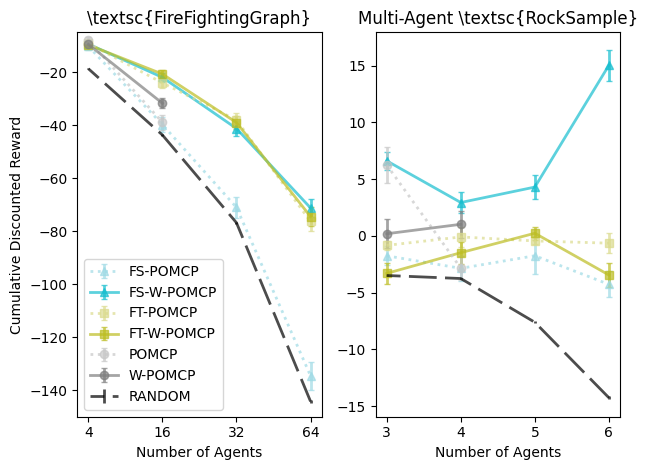

In [47]:
build_wpf_plot(copy.deepcopy(fff_results), copy.deepcopy(mars_results), outname='plot_output/wpf.pgf', even_spacing_xaxis=True, rs_map_size='15-15', discounted=True, remove_exit_map=True)

## CG PFT PLOT

[4, 16, 32, 64] [-18.724040930671002, -43.73759555390661, -76.84108917607617, -144.22958234990173]


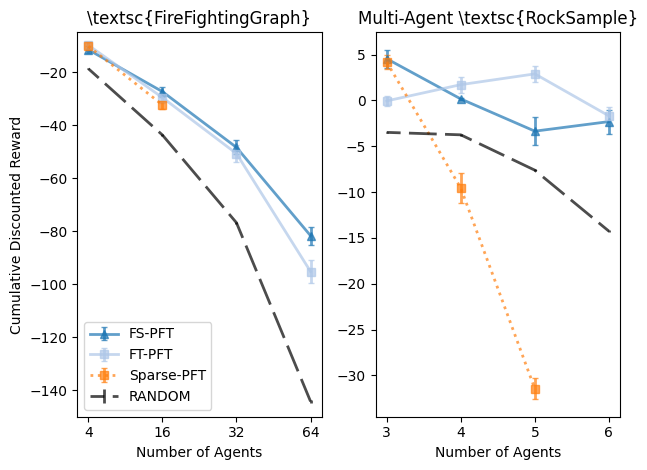

In [48]:
build_wpf_plot(copy.deepcopy(fff_results), copy.deepcopy(mars_results), pomcp=False, pft=True, remove_exit_map=True, rs_map_size='15-15', even_spacing_xaxis=True, outname='plot_output/pft.pgf', discounted=True)

## CG PFT VS CG POMCP WPF PLOT 

[4, 16, 32, 64] [-18.724040930671002, -43.73759555390661, -76.84108917607617, -144.22958234990173]


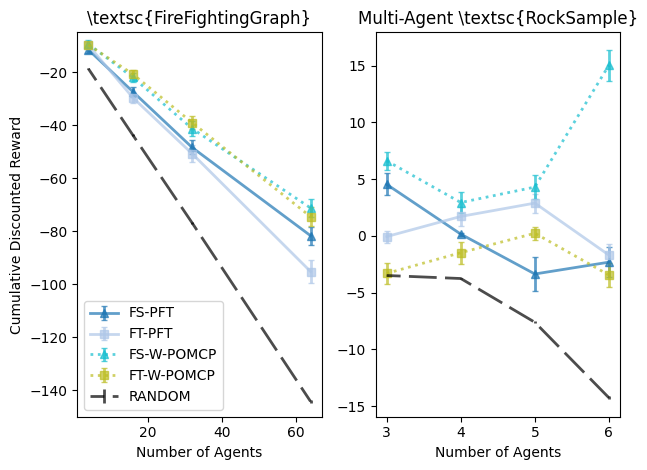

In [49]:
build_wpf_plot(copy.deepcopy(fff_results), copy.deepcopy(mars_results), pomcp=True, pft=True, solid_line=(lambda name : "PFT" in name), even_spacing_xaxis=False, only_cg=True, only_weighted=True, outname='plot_output/fight.pgf', discounted=True)

In [50]:
def build_mars_two_maps_plot(results_fff, results_mars, outname = "undefined", rs_map_sizes = ['11-11', '7-8'], solid_line = (lambda name : ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name), even_spacing_xaxis = True, only_weighted=False, only_cg=False, discounted=False, pft=False, pomcp=True, **figure_kwargs):
    # title += f" ($n_f=3$, $H=10, c=5, \gamma={0.99 if discounted else 1}$)" 
    fig = plt.figure(**figure_kwargs)
    # plt.suptitle(title)
    # MARS SUBPLOT
    plt.suptitle("Multi-Agent \\textsc{RockSample}")

    for plot, rs_map_size in enumerate(rs_map_sizes):
        plt.subplot(1, 2, plot+1)
        act_select = 'VE'
        means_dict, stds_dict = defaultdict(list), defaultdict(list)
        pft_names = set()
        pomcp_names = set()
        names = set()
        c = pomc = None
        # plt.title("\\textsc{MARS}, " + act_select)
        plt.title(f"({rs_map_size.replace('-', ', ')})")
        agents = sorted(list(results_mars.keys()))
        remove_exit_map = True
        disc_index = 'discounted' if discounted else 'undiscounted'
        if remove_exit_map: disc_index = 'undiscounted'
        randoms = []
        randoms_ci = []
        for (i, agent) in enumerate(agents):
            sim_values = results_mars[agent]
            assert 10_000 in sim_values.keys()
            sims = sorted([s for s in sim_values.keys() if type(s) == int])
            for sim in sim_values.keys():
                if type(sim) == str:
                    if agent % 2 == 0 and f'{rs_map_size}-team' not in sim:
                        continue
                    elif agent % 2 == 1 and f'{rs_map_size}-line' not in sim:
                        continue
                    res = sim_values[sim][disc_index]
                    trace = res.values
                    if remove_exit_map:
                        trace[trace < -90] = 0
                        cum_trace = np.zeros(trace.shape[0])
                        gamma = 0.95 if discounted else 1
                        for i, episode in enumerate(trace):
                            cum_trace[i] = sum([(gamma**t) * r for t, r in enumerate(episode)])
                        trace = cum_trace
                    else:
                        trace = trace.sum(axis=1)
                    # continue
                    avg, std = trace.mean(), trace.std()
                    scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
                    std = [avg - scipy_ci[0], scipy_ci[1] - avg]
                    randoms.append(avg)
                    randoms_ci.append(std)
                else:
                    for name in sim_values[sim].keys():
                        if agent % 2 == 0 and f'{rs_map_size}-team' not in name:
                            continue
                        elif agent % 2 == 1 and f'{rs_map_size}-line' not in name:
                            continue
                        if 'FPF' in name.upper(): continue
                        # if 'line_n4' in name or 'line_n6' in name:
                            # continue
                        result = sim_values[sim][name]
                        name = clean(name).upper()
                        if not act_select.upper() in name:
                            if "VE" in name.upper() or "MP" in name.upper():
                                continue
                        if 'pft' in name.lower():
                            pft_names.add(name) 
                        elif 'pomcpow' in name.lower():
                            continue
                        elif 'pomcp' in name.lower():
                            pomcp_names.add(name)
                        else:
                            print(name)
                        names.add(name)
                        trace = result[disc_index].values
                        if np.size(trace) == 0:
                            print("Experiment", name, "has empty results. Skipping..")
                            continue

                        if remove_exit_map:
                            trace[trace < -90] = 0
                            cum_trace = np.zeros(trace.shape[0])
                            gamma = 0.95 if discounted else 1
                            for i, episode in enumerate(trace):
                                cum_trace[i] = sum([(gamma**t) * r for t, r in enumerate(episode)])
                            trace = cum_trace
                        else:
                            trace = trace.sum(axis=1)

                        assert trace.ndim == 1
                        avg, std = trace.mean(axis=0), trace.std(axis=0)
                        z = 1.96 # 95%
                        std = z*(std/np.sqrt(100))
                        means_dict[name].append(avg)
                        stds_dict[name].append(std)
        if c is None:
            color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
            c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
        if pomc is None:
            color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
            pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
        for name in sorted(pft_names):
            if not pft: continue 
            means = means_dict[name]
            stds = stds_dict[name]
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            if "VE" in name.upper() or "MP" in name.upper():
                if not name.startswith('FT-') and 'FS-' not in name: continue
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            assert name in c, (name, c)
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=name.replace("-VE", "").replace("-MP", "").replace("-WPF", ""), alpha=0.7, color=c[name])
        for name in sorted(pomcp_names):
            if not pomcp: continue

            assert name in means_dict, (name, means_dict.keys())
            means = means_dict[name]
            stds = stds_dict[name]
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            assert name in pomc, (name, pomc)
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=pomc[name])
            label = name.replace("-VE", "").replace("-MP", "")
            if only_weighted: 
                if not "-WPF" in name.upper(): continue
                # label = label.replace("-WPF", "")
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            label = label.replace("POMCP-WPF", "W-POMCP")
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
            # ax = plt.plot(list(range(len(means))), means, marker=symbol(name), linewidth=2, linestyle='solid' if ours else 'dotted', label=name.replace("-VE", "").replace("-MP", ""), alpha=0.7, color=pomc[name])
            # plt.fill_between(list(range(len(means))), np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.5, color=pomc[name])
            # plt.gca().set_xticklabels(agents)
        plt.errorbar(list(range(len(randoms))) if even_spacing_xaxis else agents, randoms, yerr=np.transpose(randoms_ci), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
        if plot == 0:
            plt.legend()
        if even_spacing_xaxis: plt.xticks(list(range(len(agents))), agents)
        plt.xlabel("Number of Agents")
    # fig.supxlabel("Number of Agents")
    # fig.supylabel("Cumulative Discounted Reward")
    plt.tight_layout()
    # fig.savefig(outname + ".pdf", format='pdf', backend='pgf')
    plt.savefig(outname, backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    # return means_dict, stds_dict

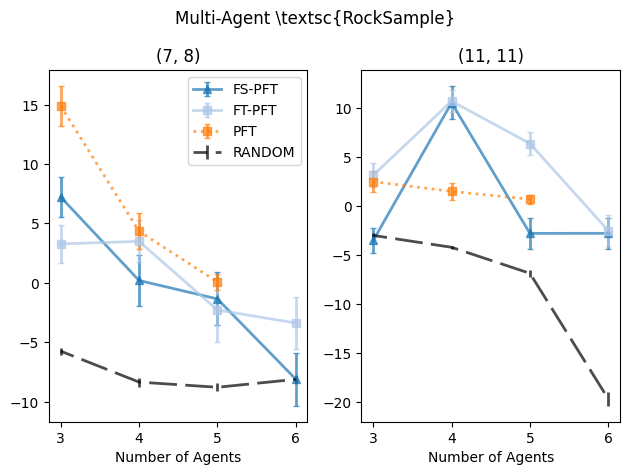

In [51]:
build_mars_two_maps_plot(fff_results, mars_results, pomcp=False, pft=True, only_weighted=False, rs_map_sizes=['7-8', '11-11'], even_spacing_xaxis=False, outname='plot_output/appendix/mars-other-maps-pft.pgf', discounted=True)

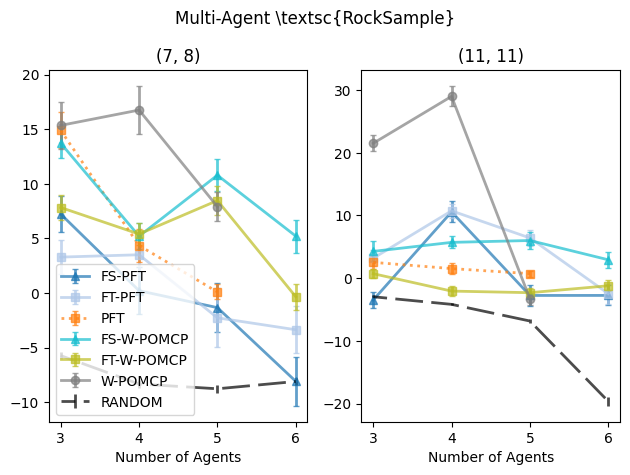

In [52]:
build_mars_two_maps_plot(fff_results, mars_results, pomcp=True, pft=True, only_weighted=True, rs_map_sizes=['7-8', '11-11'], even_spacing_xaxis=False, outname='plot_output/appendix/mars-other-maps-weighted.pgf', discounted=True)

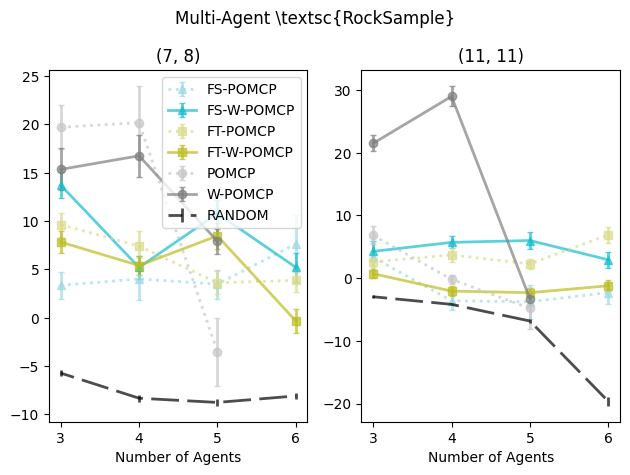

In [53]:
build_mars_two_maps_plot(fff_results, mars_results, pomcp=True, pft=False, only_weighted=False, rs_map_sizes=['7-8', '11-11'], even_spacing_xaxis=False, outname='plot_output/appendix/mars-other-maps-wpomcp.pgf', discounted=True)

# CAPTURETARGET

In [28]:
import pickle
with open('final_results/ct_pomcp_wpf_exp_results_5s.pickle', 'rb') as handle:
    ct_results = pickle.load(handle)

def clean(c : str):
    return c.replace("_", "-").replace("ct-", "").replace('line', "").replace("team", "").replace("-n6-", "").replace("-n5-", "").replace("-n4-", "").replace("-n3-", "").replace("h50-c0.5-s10000-", "")

In [41]:
def build_ct_plot(ct_results, outname = "undefined", solid_line = (lambda name : ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name), even_spacing_xaxis = True, only_weighted=False, only_cg=False, discounted=False, pft=False, pomcp=True, **figure_kwargs):
    fig = plt.figure(**figure_kwargs)
    # MARS SUBPLOT
    plt.suptitle("\\textsc{CaptureTarget}($12\\times12$)")

    for plot, act_select in enumerate(['VE', 'MP']):
        plt.subplot(1, 2, plot+1)
        means_dict, stds_dict = defaultdict(list), defaultdict(list)
        pft_names = set()
        pomcp_names = set()
        names = set()
        c = pomc = None
        # plt.title("\\textsc{MARS}, " + act_select)
        plt.title("Variable Elimination" if act_select == "VE" else "Max-Plus")
        agents = sorted(list(ct_results.keys()))
        remove_exit_map = True
        disc_index = 'discounted' if discounted else 'undiscounted'
        if remove_exit_map: disc_index = 'undiscounted'
        randoms = []
        randoms_ci = []
        for (i, agent) in enumerate(agents):
            sim_values = ct_results[agent]
            assert 10_000 in sim_values.keys()
            sims = sorted([s for s in sim_values.keys() if type(s) == int])
            for sim in sim_values.keys():
                if type(sim) == str:
                    if agent % 2 == 0 and 'ct-team' not in sim:
                        continue
                    elif agent % 2 == 1 and 'ct-line' not in sim:
                        continue
                    res = sim_values[sim][disc_index]
                    trace = res.values
                    if remove_exit_map:
                        trace[trace < -90] = 0
                        cum_trace = np.zeros(trace.shape[0])
                        gamma = 0.95 if discounted else 1
                        for i, episode in enumerate(trace):
                            cum_trace[i] = sum([(gamma**t) * r for t, r in enumerate(episode)])
                        trace = cum_trace
                    else:
                        trace = trace.sum(axis=1)
                    # continue
                    avg, std = trace.mean(), trace.std()
                    scipy_ci = scipy.stats.norm.interval(0.95, loc=avg, scale=scipy.stats.sem(trace))
                    std = [avg - scipy_ci[0], scipy_ci[1] - avg]
                    randoms.append(avg)
                    randoms_ci.append(std)
                else:
                    for name in sim_values[sim].keys():
                        if agent % 2 == 0 and 'ct-team' not in name:
                            continue
                        elif agent % 2 == 1 and 'ct-line' not in name:
                            continue
                        if 'FPF' in name.upper(): continue
                        # if 'line_n4' in name or 'line_n6' in name:
                            # continue
                        result = sim_values[sim][name]
                        name = clean(name).upper()
                        if not act_select.upper() in name:
                            if "VE" in name.upper() or "MP" in name.upper():
                                continue
                        if 'pft' in name.lower():
                            pft_names.add(name) 
                        elif 'pomcpow' in name.lower():
                            continue
                        elif 'pomcp' in name.lower():
                            pomcp_names.add(name)
                        else:
                            print(name)
                        names.add(name)
                        trace = result[disc_index].values
                        if np.size(trace) == 0:
                            print("Experiment", name, "has empty results. Skipping..")
                            continue

                        if remove_exit_map:
                            trace[trace < -90] = 0
                            cum_trace = np.zeros(trace.shape[0])
                            gamma = 0.95 if discounted else 1
                            for i, episode in enumerate(trace):
                                cum_trace[i] = sum([(gamma**t) * r for t, r in enumerate(episode)])
                            trace = cum_trace
                        else:
                            trace = trace.sum(axis=1)

                        assert trace.ndim == 1
                        avg, std = trace.mean(axis=0), trace.std(axis=0)
                        z = 1.96 # 95%
                        std = z*(std/np.sqrt(100))
                        means_dict[name].append(avg)
                        stds_dict[name].append(std)
        if c is None:
            color_map_pft = cmap_pft(np.linspace(0.25, 1, len(pft_names))) if linear_colours else cmap_pft.colors
            c = {name : color_map_pft[i] for i, name in enumerate(sorted(pft_names))}
        if pomc is None:
            color_map_pomcp = cmap_pomcp(np.linspace(0.25, 1, len(pomcp_names))) if linear_colours else list(reversed(cmap_pomcp.colors))
            pomc = {name : color_map_pomcp[i] for i, name in enumerate(sorted(pomcp_names))}
        for name in sorted(pft_names):
            if not pft: continue 
            means = means_dict[name]
            stds = stds_dict[name]
            ours = ('wpf' in name.lower() or 'pft' in name.lower()) and not "PFT-WPF" == name
            if "VE" in name.upper() or "MP" in name.upper():
                if not name.startswith('FT-') and 'FS-' not in name: continue
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            assert name in c, (name, c)
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            # ax = plt.errorbar(sims, means, yerr=np.transpose(stds), linestyle='solid' if ours else 'dotted', marker='^', capsize=3, linewidth=2, label=name, alpha=0.7, color=c[name])
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=name.replace("-VE", "").replace("-MP", "").replace("-WPF", ""), alpha=0.7, color=c[name])
        for name in sorted(pomcp_names):
            if not pomcp: continue

            assert name in means_dict, (name, means_dict.keys())
            means = means_dict[name]
            stds = stds_dict[name]
            if "VE" in name.upper() or "MP" in name.upper():
                assert len(means) == len(agents) == len(stds), (name, (means, stds, agents))
            assert name in pomc, (name, pomc)
            label = name.replace("-VE", "").replace("-MP", "")
            if only_weighted:
                if not "-WPF" in name.upper(): continue
            if only_cg and not name.startswith('FT-') and 'FS-' not in name: continue
            label = label.replace("POMCP-WPF", "W-POMCP")
            ax = plt.errorbar(list(range(len(means))) if even_spacing_xaxis else agents[:len(means)], means, yerr=np.transpose(stds), fmt=symbol(name), capsize=2, linewidth=2, linestyle='solid' if solid_line(name) else 'dotted', label=label, alpha=0.7, color=pomc[name])
        plt.errorbar(list(range(len(randoms))) if even_spacing_xaxis else agents, randoms, yerr=np.transpose(randoms_ci), label='RANDOM', linestyle=(5, (10, 3)), linewidth=2, c='black', alpha=0.7)
        if plot == 1:
            plt.legend()
        if even_spacing_xaxis: plt.xticks(list(range(len(agents))), agents)
        plt.xlabel("Number of Agents")
        plt.ylabel("Capture Rate")
        plt.ylim([-0.05, 1.05])
    plt.tight_layout()
    plt.savefig(outname, backend='pgf', format='pgf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

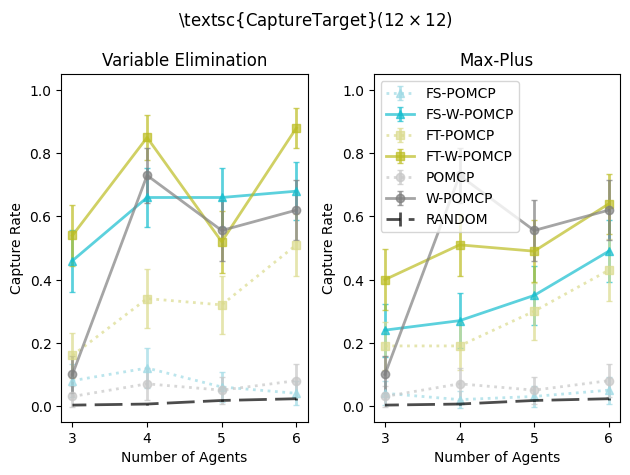

In [42]:
build_ct_plot(ct_results, only_weighted=False, pft=False, pomcp=True, discounted=False, outname='plot_output/ct-pomcp.pgf')